In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from gru2 import GRUModel
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

(5000, 50, 1)


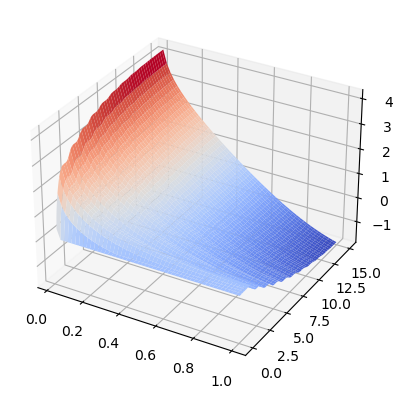

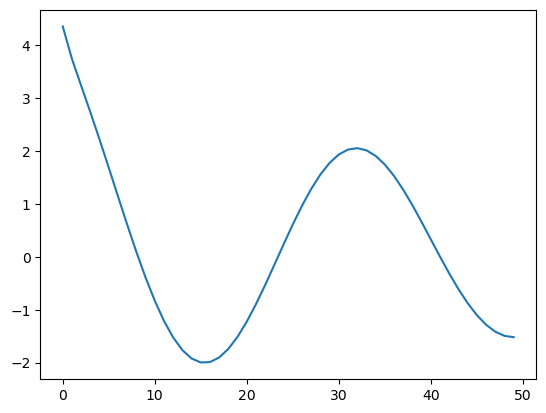

In [2]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)

for i in range(npoints):
    for j in range(int(nt/sampleRate)):
        for k in range(nx):
            xArr[i*int(nt/sampleRate)+j] = x[i, int(j*sampleRate), :]
            yArr[i*int(nt/sampleRate)+j] = y[i, int(j*sampleRate), :]
x=xArr.reshape((npoints*int(nt/sampleRate), nx, 1))
y=yArr.reshape((npoints*int(nt/sampleRate), nx, 1))

plt.figure()
plt.plot(xArr[28])
print(x.shape)
#plt.figure()
#plt.plot(y[0])

In [3]:
# Parameters
epochs =1000
ntrain = 900
ntest = 100
batch_size = 50
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes = 12
width = 32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
#model = GRUModel(300, 1024, 300, 1, 3, [512, 128, 64]).cuda()
model = GRUModel(500, 1, 1).cuda()
print(count_params(model))

755001


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
t = default_timer()
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)

        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)

0 0.4223574991337955 0.46344098564651276 0.23297144770622252
50 0.22961255488917232 0.0151796642690897 0.013242147769778967
100 0.23458370612934232 0.009179042714337508 0.008198741171509028
150 0.23225005576387048 0.0054499245326345164 0.0058929075486958025
200 0.2324291728436947 0.0038471610233601597 0.004229186731390655
250 0.2307511861436069 0.0031285554429309236 0.003018247405998409
300 0.2346758982166648 0.002811376853949494 0.0027426361804828046
350 0.2727460819296539 0.002645551953982148 0.002610104810446501
400 0.23166563315317035 0.00253089036171635 0.0024681944050826132
450 0.23210400668904185 0.0024607098014611337 0.0024253220297396185
500 0.23191463202238083 0.0024315309012308715 0.0024007029714994133
550 0.2316191759891808 0.0024120847888601323 0.0023835240863263607
600 0.23212802223861217 0.002401849835748888 0.0023760246112942696
650 0.23158067325130105 0.002398203561703364 0.0023717481060884895
700 0.23161945631727576 0.0023945372111888394 0.0023702797014266254
750 0.23

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


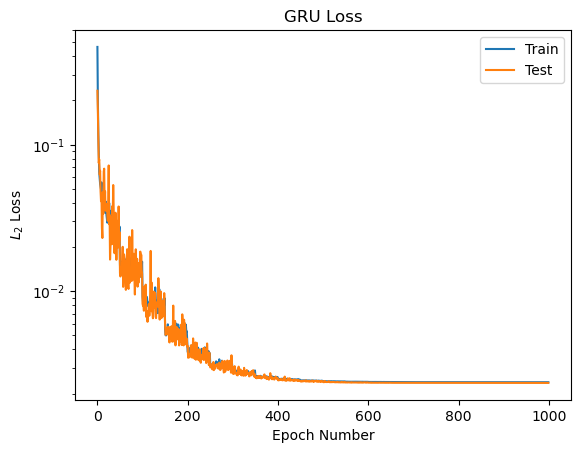

In [9]:
plt.title("GRU Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('gru.eps')

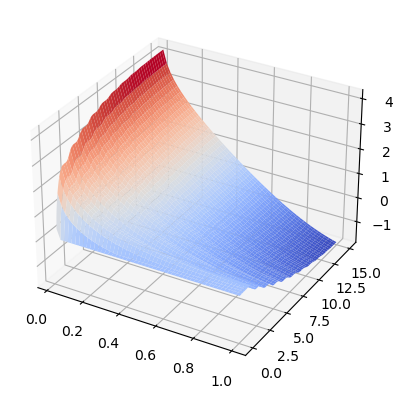

In [23]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)


In [24]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 12
width = 64

In [25]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [29]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        outTensor = torch.from_numpy(np.zeros((batch_size, x.shape[1], x.shape[2]), dtype=np.float32)).cuda()
        for timeStep in range(x.shape[1]):
            out = model(x[:, timeStep, :].reshape(batch_size, x.shape[2], 1))
            outTensor[:, timeStep, :] = out.reshape(batch_size, x.shape[2])

        test_mse += loss(outTensor, y).item()
print("TEST MSE For " + str(batch_size) + " Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.003996947733685374


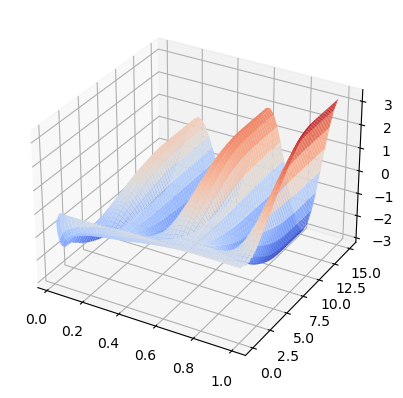

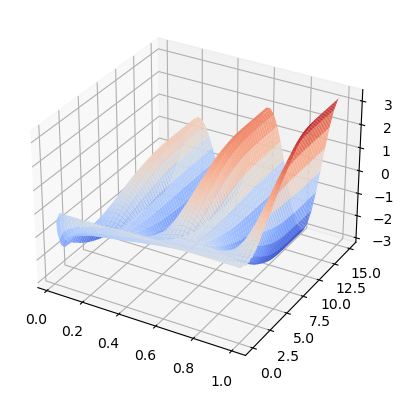

In [30]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, outTensor[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)

In [31]:
torch.save(model.state_dict(), 'gruModel2')